In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Building ARIMA Models
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Libraries for Evaluation
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
%matplotlib inline

In [3]:
# load dataset
df_MRO = pd.read_csv('./datasets/MRO.csv', header=0, index_col=0)
df_MRO.head()

,Open,High,Low,Close,Volume
Date,,,,,
6/11/2018,21.01,21.64,20.86,21.47,"10,121,701"
6/12/2018,21.48,21.64,21.22,21.36,"10,768,772"
6/13/2018,21.23,21.62,21.19,21.47,"11,237,962"
6/14/2018,21.61,21.67,21.07,21.12,"9,308,231"
6/15/2018,21.01,21.05,19.88,19.99,"22,233,950"


<class 'pandas.core.frame.DataFrame'>
Index: 1258 entries, 6/11/2018 to 6/8/2023
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1258 non-null   float64
 1   High    1258 non-null   float64
 2   Low     1258 non-null   float64
 3   Close   1258 non-null   float64
 4   Volume  1258 non-null   object 
dtypes: float64(4), object(1)
memory usage: 59.0+ KB


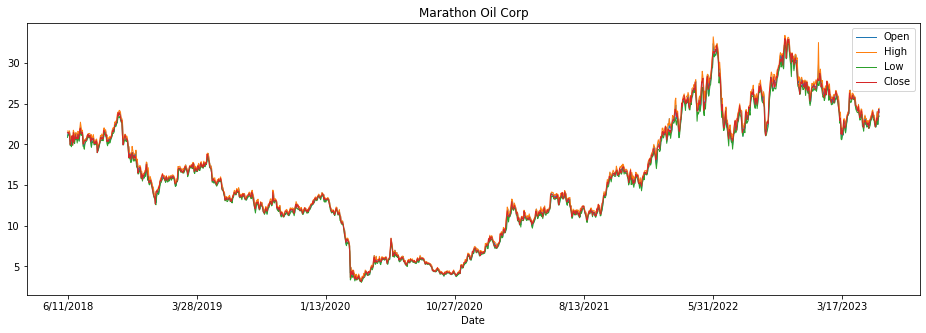

In [4]:
df_MRO.info()
df_MRO.plot(figsize=(16,5),lw=1, title="Marathon Oil Corp")
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

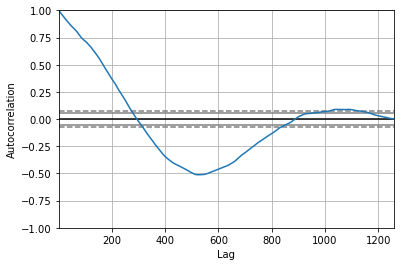

In [5]:
autocorrelation_plot(df_MRO[["Open","High","Low","Close"]])

### Choosing Close Columns for model predictions

<class 'pandas.core.series.Series'>
Index: 1258 entries, 6/11/2018 to 6/8/2023
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
1258 non-null   float64
dtypes: float64(1)
memory usage: 19.7+ KB


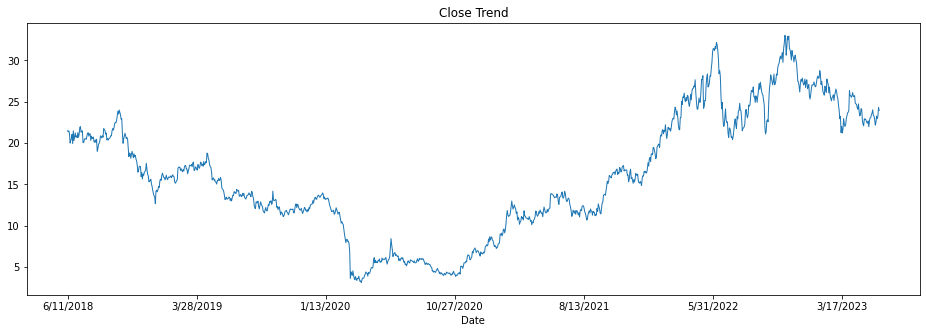

In [6]:
df_close = df_MRO["Close"]
df_close.info()
df_close.plot(figsize=(16,5),lw=1, title="Close Trend")
plt.show()

### Split data for train and test

In [53]:
# Split the data for train and test
df_train = df_close[:1200].copy()
df_test = df_close[1200:].copy()

In [13]:
# Creating function to display ACF anf PACF plot
def plot_correlation(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5), dpi=80)
    # ACF
    plot_acf(df, ax=ax1, lags=30)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    
    # PACF
    plot_pacf(df, ax=ax2, lags=20)
    plt.xlabel('Lag')
    plt.ylabel('Partial Autocorrelation')

    # Lighten the borders
    ax1.spines['top'].set_alpha(.3); ax2.spines['top'].set_alpha(.3)
    ax1.spines['bottom'].set_alpha(.3); ax2.spines['bottom'].set_alpha(.3)
    ax1.spines['right'].set_alpha(.3); ax2.spines['right'].set_alpha(.3)
    ax1.spines['left'].set_alpha(.3); ax2.spines['left'].set_alpha(.3)

    ax1.tick_params(axis='both', labelsize=10)
    ax2.tick_params(axis='both', labelsize=10)
    plt.show()

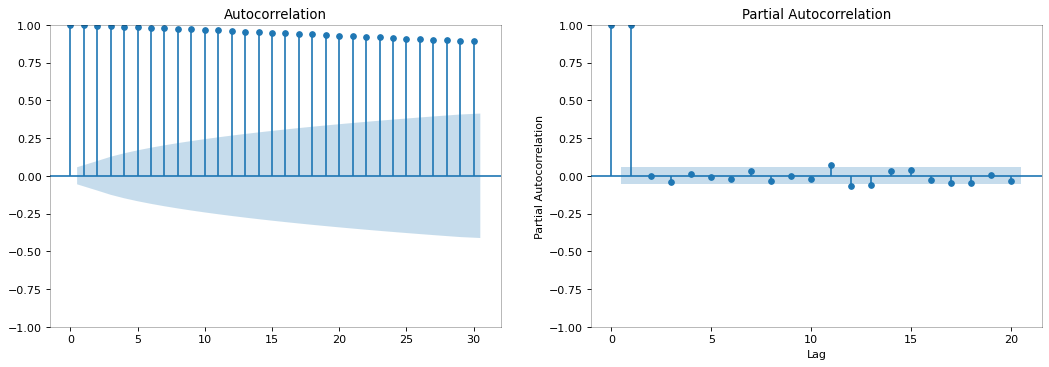

In [14]:
plot_correlation(df_train)

### Get p-value with ADF and KPSS test

In [15]:
#perform augmented Dickey-Fuller test to check if stationary
def ADF(df):
    result = adfuller(df)

    # Extract ADF Values
    print('Column Name: %s' % "Close Variable")
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [21]:
ADF(df_train)

Column Name: Close Variable
ADF Statistic: -1.231883
p-value: 0.659732
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [17]:
# KPSS Test 
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c")
    kpss_output = pd.Series(kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"])
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [20]:
kpss_test(df_train.values)

Results of KPSS Test:
Test Statistic            2.102428
p-value                   0.010000
Lags Used                20.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


## Transform to stationary

p.value: -0.4599999999999973


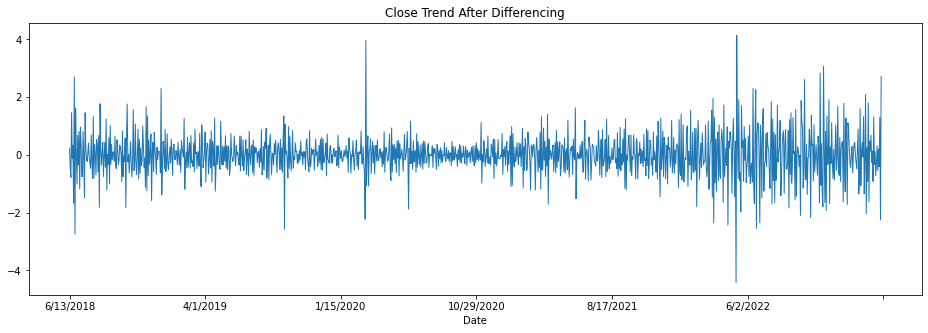

In [22]:
# Perform differencing
df_train_diff = df_train.diff().diff().dropna()
df_train_diff.plot(figsize=(16,5), lw=1, title="Close Trend After Differencing")
print(f"p.value: {df_train_diff[1]}" )
plt.show()

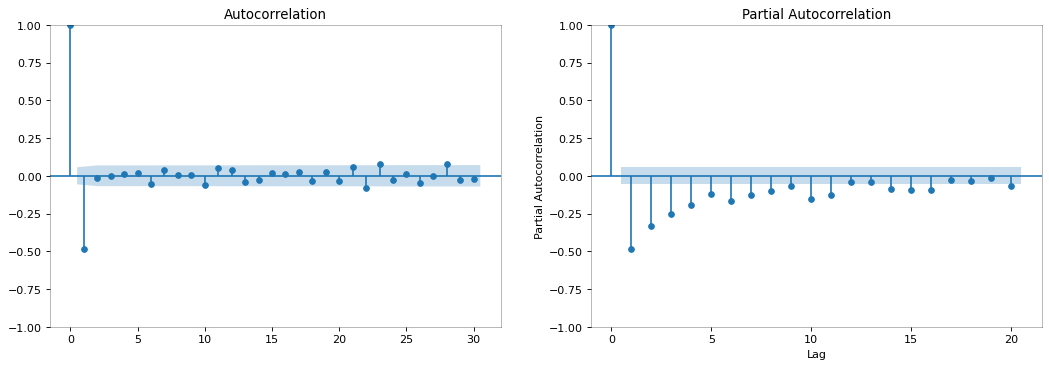

In [23]:
plot_correlation(df_train_diff)

## Determine model parameters p, q

In [24]:
# library that determine best parameters for ARIMA model
import pmdarima as pm
from pmdarima import auto_arima

In [45]:
model = auto_arima(df_train, start_p=0, start_q=0,
                          max_p=2, max_q=3,m=12,start_P=0,start_Q=0, 
                          max_P = 2, max_Q = 3,
                          seasonal=True,
                          d=2,D=2,trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,2,0)[12]             : AIC=4610.351, Time=0.44 sec
 ARIMA(1,2,0)(1,2,0)[12]             : AIC=3713.814, Time=1.08 sec
 ARIMA(0,2,1)(0,2,1)[12]             : AIC=inf, Time=6.60 sec
 ARIMA(1,2,0)(0,2,0)[12]             : AIC=4280.216, Time=0.50 sec
 ARIMA(1,2,0)(2,2,0)[12]             : AIC=3298.720, Time=1.74 sec
 ARIMA(1,2,0)(2,2,1)[12]             : AIC=inf, Time=16.00 sec
 ARIMA(1,2,0)(1,2,1)[12]             : AIC=inf, Time=8.91 sec
 ARIMA(0,2,0)(2,2,0)[12]             : AIC=3641.232, Time=1.38 sec
 ARIMA(2,2,0)(2,2,0)[12]             : AIC=3192.853, Time=2.03 sec
 ARIMA(2,2,0)(1,2,0)[12]             : AIC=3599.685, Time=1.11 sec
 ARIMA(2,2,0)(2,2,1)[12]             : AIC=inf, Time=25.88 sec
 ARIMA(2,2,0)(1,2,1)[12]             : AIC=inf, Time=9.67 sec
 ARIMA(2,2,1)(2,2,0)[12]             : AIC=inf, Time=14.61 sec
 ARIMA(1,2,1)(2,2,0)[12]             : AIC=inf, Time=21.62 sec
 ARIMA(2,2,0)(2,2,0)[12] intercept   : AIC=3194.85

## Fit the ARIMA Model

In [60]:
model = ARIMA(df_train, order=(2,2,0))
model_fit = model.fit()
print(model_fit.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1200
Model:                 ARIMA(2, 2, 0)   Log Likelihood               -1117.229
Date:                Thu, 15 Jun 2023   AIC                           2240.458
Time:                        14:38:45   BIC                           2255.723
Sample:                             0   HQIC                          2246.208
                               - 1200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6516      0.020    -33.185      0.000      -0.690      -0.613
ar.L2         -0.3319      0.020    -16.780      0.000      -0.371      -0.293
sigma2         0.3779      0.009     42.443      0.0

## Make time series prediction

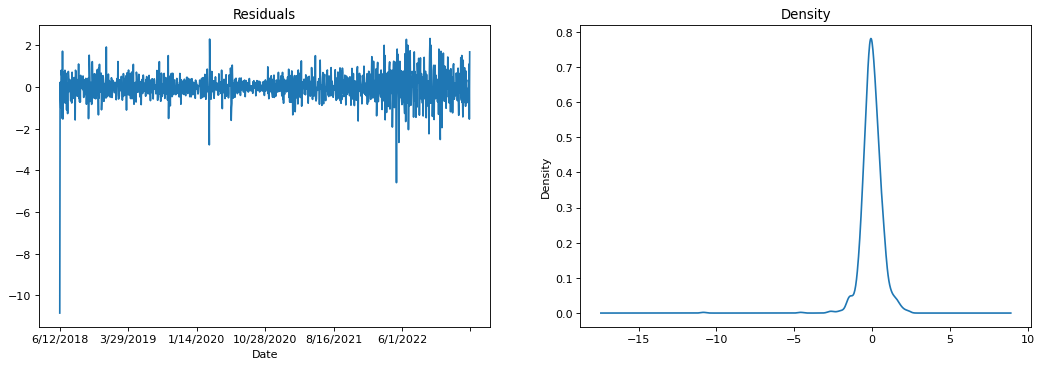

In [61]:
# Getting residuals pattern
# To make sure model capture adequate information from the data
residuals = model_fit.resid[1:]
fig,ax=plt.subplots(1,2, figsize=(16,5), dpi=80)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

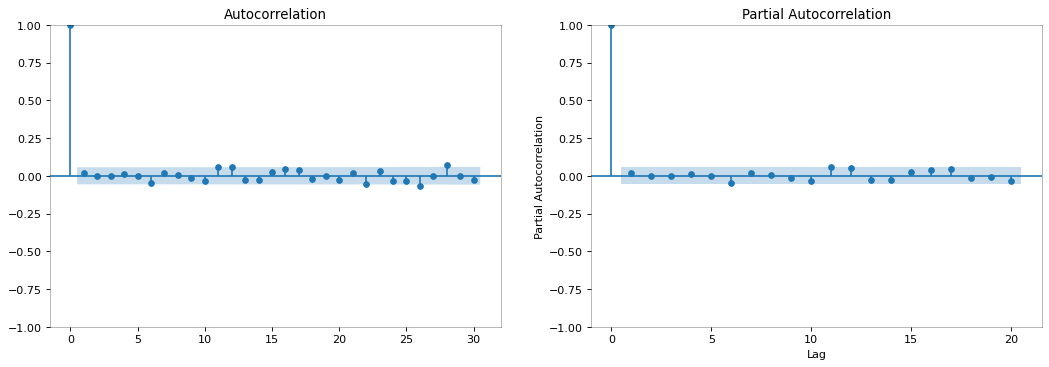

In [29]:
plot_correlation(residuals)

In [62]:
forecast = model_fit.forecast(len(df_test))

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [63]:
forecast.index = df_test.index
new_df = pd.concat([forecast, df_test], axis=1)
new_df

,predicted_mean,Close
Date,,
3/17/2023,21.734448,21.20
3/20/2023,21.224292,21.74
3/21/2023,21.207433,22.96
3/22/2023,20.947004,22.28
3/23/2023,20.681545,22.00
3/24/2023,20.500215,22.16
3/27/2023,20.265734,22.90
3/28/2023,20.037962,23.27
3/29/2023,19.823461,23.64


<AxesSubplot:xlabel='Date'>

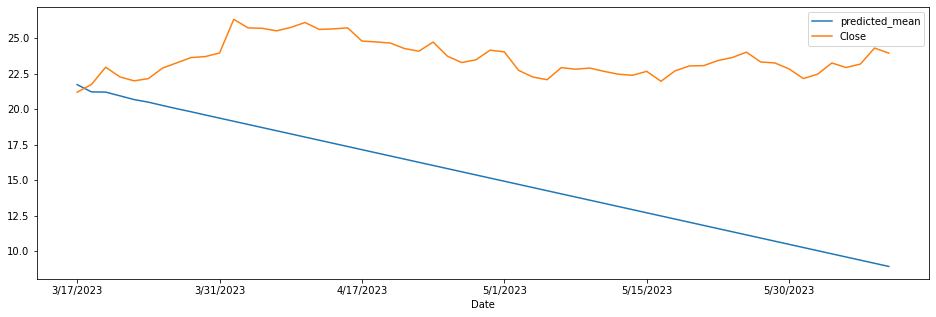

In [64]:
new_df.plot(figsize=(16,5))

## Fit the SARIMAX Model

In [65]:
train = df_close[:1200].copy()
test = df_close[1200:].copy()

In [66]:
final_model = SARIMAX(train,order=(2,2,0),seasonal_order=(2,2,0,12)) # Best model:  ARIMA(2,2,0)(2,2,0)[12]     
result = final_model.fit()
print(result.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.41693D+00    |proj g|=  4.24424D-01


 This problem is unconstrained.



At iterate    5    f=  1.23605D+00    |proj g|=  7.87880D-02

At iterate   10    f=  1.20342D+00    |proj g|=  2.23972D-02

At iterate   15    f=  1.19601D+00    |proj g|=  2.05344D-02

At iterate   20    f=  1.19506D+00    |proj g|=  3.01035D-03

At iterate   25    f=  1.19498D+00    |proj g|=  9.56969D-04

At iterate   30    f=  1.19498D+00    |proj g|=  1.81455D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     39      1     0     0   1.672D-04   1.195D+00
  F =   1.1949779860909429     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                      SARIMAX Resul

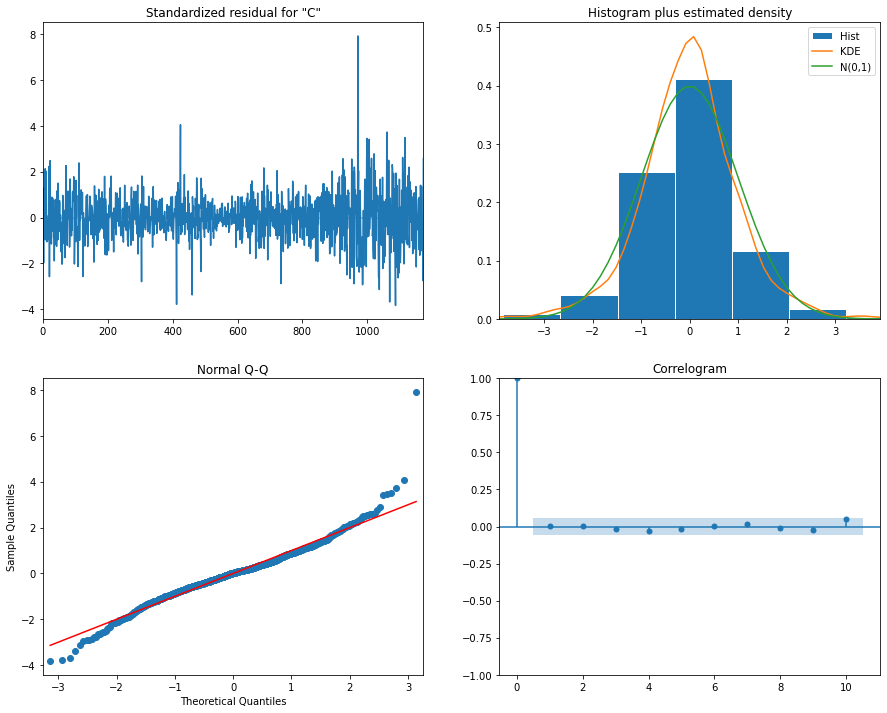

In [67]:
result.plot_diagnostics(figsize=(15, 12));

In [68]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
# Best model:  ARIMA(2,2,0)(2,2,0)[12]
predictions = result.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(2,2,0)(2,2,0,12) Predictions')# Plot predictions against known values

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [69]:
predictions.index = test.index
joined_df = pd.concat([predictions, test], axis=1)
joined_df

,"SARIMA(2,2,0)(2,2,0,12) Predictions",Close
Date,,
3/17/2023,22.825123,21.20
3/20/2023,22.967647,21.74
3/21/2023,23.296003,22.96
3/22/2023,22.395230,22.28
3/23/2023,21.921337,22.00
3/24/2023,21.365900,22.16
3/27/2023,20.427268,22.90
3/28/2023,19.608326,23.27
3/29/2023,18.361606,23.64


[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Production')]

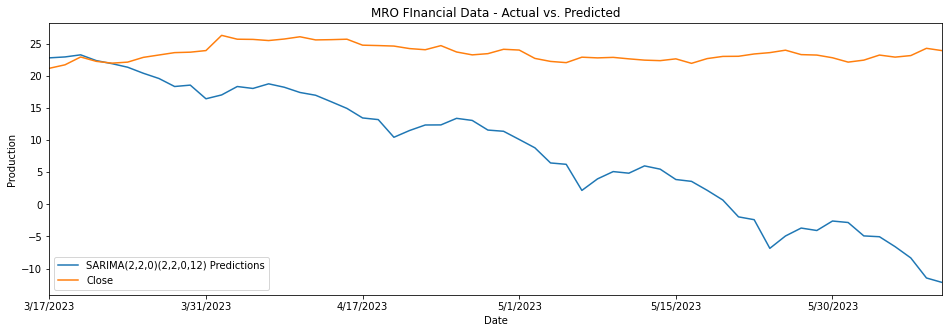

In [70]:
title = 'MRO FInancial Data - Actual vs. Predicted'
ylabel='Production'
xlabel='Date'
ax = joined_df.plot(legend=True, figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)